In [1]:
from csdid.ATTgt import ATTgt
from csdid.plots import splot

In [2]:
import findspark
import warnings
findspark.init()
import numpy as np

from pyspark.sql import  SparkSession, Row
from pyspark.sql.functions import \
	lit, col, when, expr, countDistinct,\
	monotonically_increasing_id, desc
spark = SparkSession.builder.appName('test_preprocesdid')\
    .config('spark.master', 'local[4]')\
    .config('spark.executor.memory', '2g')\
    .config("spark.sql.shuffle.partitions", 10)\
    .config('spark.driver.memory','1g')\
    .getOrCreate()

In [3]:
%%time
import os

# name = 'https://raw.githubusercontent.com/d2cml-ai/csdid/function-aggte/data/mpdta.csv'
name = r'D:\Workflow\work\csdid_r\R\5g10t.csv'
name = r'D:\Workflow\work\csdid_r\R\data\mpdta.csv'
# os.path.exists(name)

yname, gname, idname, tname = 'Y', 'G', 'id', 'period'
yname, gname, idname, tname = 'lemp', 'first_treat', 'countyreal', 'year'
# yname, gname, idname, tname = 'lemp', 'first.treat', 'countyreal', 'year'
control_group = ['nevertreated', 'notyettreated']
anticipation = 0
panel = True
allow_unbalanced_panel = True
weights_name = None

clustervar = None
xfmla = None

data = spark.read.csv(name, header=True, inferSchema=True)
# data.show(5)
a = ATTgt(data=data, tname=tname, gname=gname, yname=yname, idname=idname)
a.fit(bstrap=True)

100%|██████████| 3/3 [00:09<00:00,  3.20s/it]

CPU times: total: 594 ms
Wall time: 15.3 s


In [4]:
# a.sum_gt().summary2_gt

In [5]:
a.compute_aggte(na_rm=False, typec='simple')
a.compute_aggte(na_rm=False, typec='group')
a.compute_aggte(na_rm=False, typec='calendar')



   ATT Std. Error  [95.0%  Conf. Int.] 
0.0418     0.0558 -0.0676       0.1512 


---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




Overall summary of ATT's based on group/cohort aggregation:
   ATT Std. Error  [95.0%  Conf. Int.] 
0.0678     0.0633 -0.0563       0.1918 


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band  
0   2004   -0.0337      0.0644          -0.1600      0.0926  
1   2006    0.0309      0.0576          -0.0820      0.1437  
2   2007    0.0945      0.0761          -0.0547      0.2438  
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




Overall summary of ATT's based on calendar time aggregation:
    ATT Std. Error  [95.0%  Conf. Int.] 
-0.0072     0.0419 -0.0894        0.075 


Time Effects (calendar):
   Time  Estimate  Std. Error  [95.0% Simult.   Conf. B

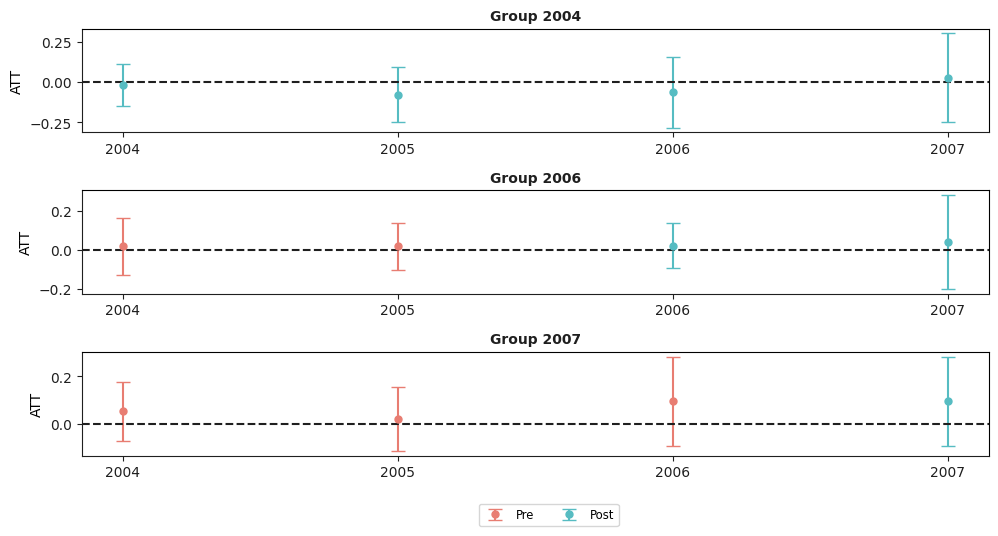

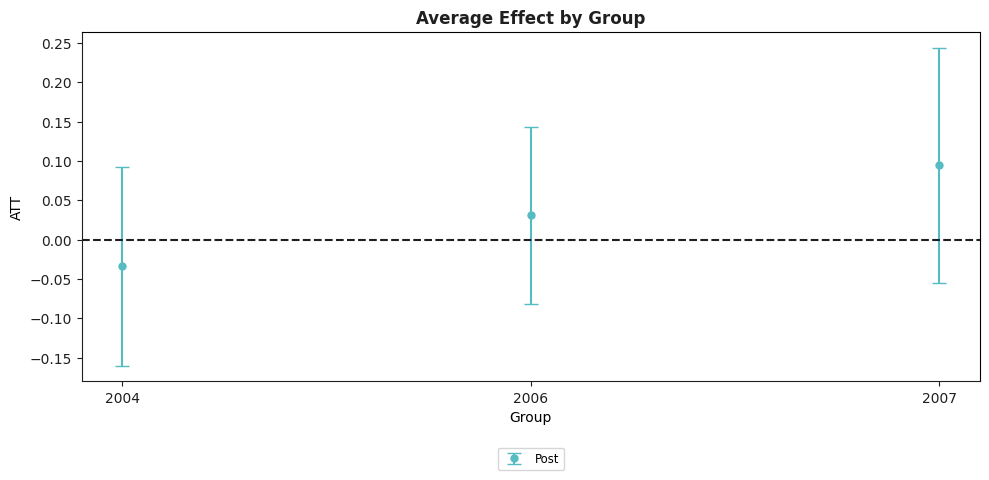

In [6]:

a.plot_attgt();
a.plot_aggte();